In [1]:
import os

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import seaborn as sns
import json

hp = json.load(open("../dylam_hyperparameters.json", "r"))
sns.set(style="white", rc={"grid.color": "lightgray"})
plt.rcParams["figure.dpi"] = 150

In [2]:
environments = [x for x in os.listdir(".") if os.path.isdir(x) for x in ["RaceTrack"]]
environments = list(set(environments))
results = {env: pd.read_csv(os.path.join(env, "results.csv")) for env in environments}
lambdas = {
    env: [
        pd.read_csv(os.path.join(env, lambda_))
        for lambda_ in [x for x in sorted(os.listdir(env)) if x.startswith("lambda")]
    ]
    for env in environments
}
components = {
    env: [
        pd.read_csv(os.path.join(env, comp))
        for comp in [x for x in sorted(os.listdir(env)) if x.startswith("component")]
    ]
    for env in environments
}
env_steps = {
    "RaceTrack": 2000 - 50,
}
env_alphas = {
    "RaceTrack": 1 - 0.9,
}
env_ylimits = {
    "RaceTrack": (0, 1000),
}
colors = {
    "DyLam": "red",
    "Q-Learning": "cornflowerblue",
    "Local-Q": "green",
}
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1, 1))

In [3]:
def calculate_ema(data, alpha):
    ema = np.zeros_like(data)  # Initialize an array for the EMA values
    ema[0] = data[0]  # Set the initial value of the EMA to the first data point

    for i in range(1, len(data)):
        ema[i] = alpha * data[i] + (1 - alpha) * ema[i - 1]  # Calculate the EMA

    return ema

In [9]:
def plot_results(env, results):
    methods = list(
        set(
            [
                x.split(" - ep_info/")[0].split(" ")[1]
                for x in results[env].keys()
                if x != "Step"
            ]
        )
    )
    # plot figure
    rew_name = results[env].keys()[1].split(" - ep_info/")[1]
    plt.figure(figsize=(10, 5))
    for method in methods:
        # Mean
        res = results[env][["Step", f"method: {method} - ep_info/{rew_name}"]].dropna()
        res["Smoothed"] = calculate_ema(
            res[f"method: {method} - ep_info/{rew_name}"].values,
            env_alphas[env],
        )
        x = res["Step"][res["Step"] <= env_steps[env]]
        y = res["Smoothed"][res["Step"] <= env_steps[env]]
        plt.plot(
            x,
            y,
            label=method,
            color=colors[method],
        )
        std_error = res[f"method: {method} - ep_info/{rew_name}"].std()
        plt.fill_between(
            x,
            y - std_error,
            y + std_error,
            alpha=0.1,
            color=colors[method],
        )
    plt.legend(prop={"size": 20}, loc="upper right")
    plt.title(rew_name.capitalize().replace("_", " "), fontsize=14, fontweight="bold")
    plt.ylim(env_ylimits[env])
    plt.gca().yaxis.set_major_formatter(formatter)
    plt.gca().xaxis.set_major_formatter(formatter)
    plt.xlabel("Steps", fontsize=14)
    plt.tick_params(axis="both", labelsize=12)
    plt.grid(True)
    plt.savefig(f"{env}/results.png")
    plt.show()


In [49]:
import math


def plot_grid(lambdas, components, env):
    if len(lambdas[env]) < 3:
        nrows = 1
        ncols = len(lambdas[env])
        size = (8, 2)
    elif len(lambdas[env]) < 7:
        size = (8, 4)
        nrows = math.ceil(len(lambdas[env]) / 2)
        ncols = math.ceil(len(lambdas[env]) / 2)
    elif len(lambdas[env]) == 7:
        size = (16, 8)
        nrows = 3
        ncols = 3
    fig, axes = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        figsize=size,
        sharex=True,
    )
    # Adjust the spacing between subplots
    plt.subplots_adjust(hspace=0.2, wspace=0.35)
    if len(lambdas[env]) == 3:
        fig.delaxes(axes[1, 1])
    if len(lambdas[env]) == 7:
        fig.delaxes(axes[2, 1])
        fig.delaxes(axes[2, 2])
        

    for i, lmbda in enumerate(lambdas[env]):
        if len(lambdas[env]) == 2:
            ax1 = axes[i]
        elif len(lambdas[env]) < 7:
            ax1 = axes[i // 2, i % 2]
        elif len(lambdas[env]) == 7:
            ax1 = axes[i // 3, i % 3]
        # Apply moving average smoothing
        window_size = 100
        weights = np.repeat(1.0, window_size) / window_size
        key = components[env][i].keys()[1]
        com = components[env][i][key]
        smoothed = np.convolve(com, weights, "same")
        comp_key = components[env][i].keys()[1].split("ep_info/")[1].title()
        x = components[env][i]["Step"][components[env][i]["Step"] <= env_steps[env]]
        y = smoothed[components[env][i]["Step"] <= env_steps[env]]
        (p1,) = ax1.plot(
            x,
            y,
            color="red",
            alpha=0.5,
            label="Reward",
        )

        ax1.title.set_text(comp_key)
        ax1.title.set_fontsize(10 if len(lambdas[env]) != 2 else 12)
        ax1.title.set_fontweight("bold")
        ax1.tick_params(axis="y", labelcolor="red")
        # plot rew_max and rew_min as tracejed red lines
        ax1.axvline(color="grey")
        ax1.axhline(color="grey")
        ax1.grid(True)
        if len(lambdas[env]) != 2:
            ax1.tick_params(axis="both", labelsize=10)

        ax1.yaxis.set_major_formatter(formatter)
        ax1.xaxis.set_major_formatter(formatter)
        if len(lambdas[env]) == 4 and i>1:
            ax1.xaxis.set_label_text("Steps")
        

        ax1_twin = ax1.twinx()
        ax1_twin.grid(True)
        x = lmbda["Step"][lmbda["Step"] <= env_steps[env]]
        y = lmbda[lmbda.keys()[1]][lmbda["Step"] <= env_steps[env]]

        (p2,) = ax1_twin.plot(
            x,
            y,
            color="blue",
            label="Lambda",
        )
        # gonca_env_key = [kky for kky in hp.keys() if env in kky][0]
        # gonca_lambori = [hp[gonca_env_key]["lambdas"][i]]*len(x)
        # (p3,) = ax1_twin.plot(
        #     x,
        #     gonca_lambori,
        #     "--",
        #     color="blue",
        #     label="Lambda Original",
        # )
        ax1_twin.tick_params(axis="y", labelcolor="blue")

        ax1_twin.set_yticks([0, 0.5, 1])
    leg_loc = {
        2: "lower center",
        3: "upper center",
        4: "upper center",
        7: "upper center",
    }
    fig.legend(
        handles=[p1, p2],
        loc=leg_loc[len(lambdas[env])],
        bbox_to_anchor=(0.5, 1.05),
        ncol=2,
        fancybox=True,
        shadow=True,
    )
    fig.set_dpi(300)
    plt.savefig(f"{env}/DyLam_analysis.png", bbox_inches="tight")
    plt.show()


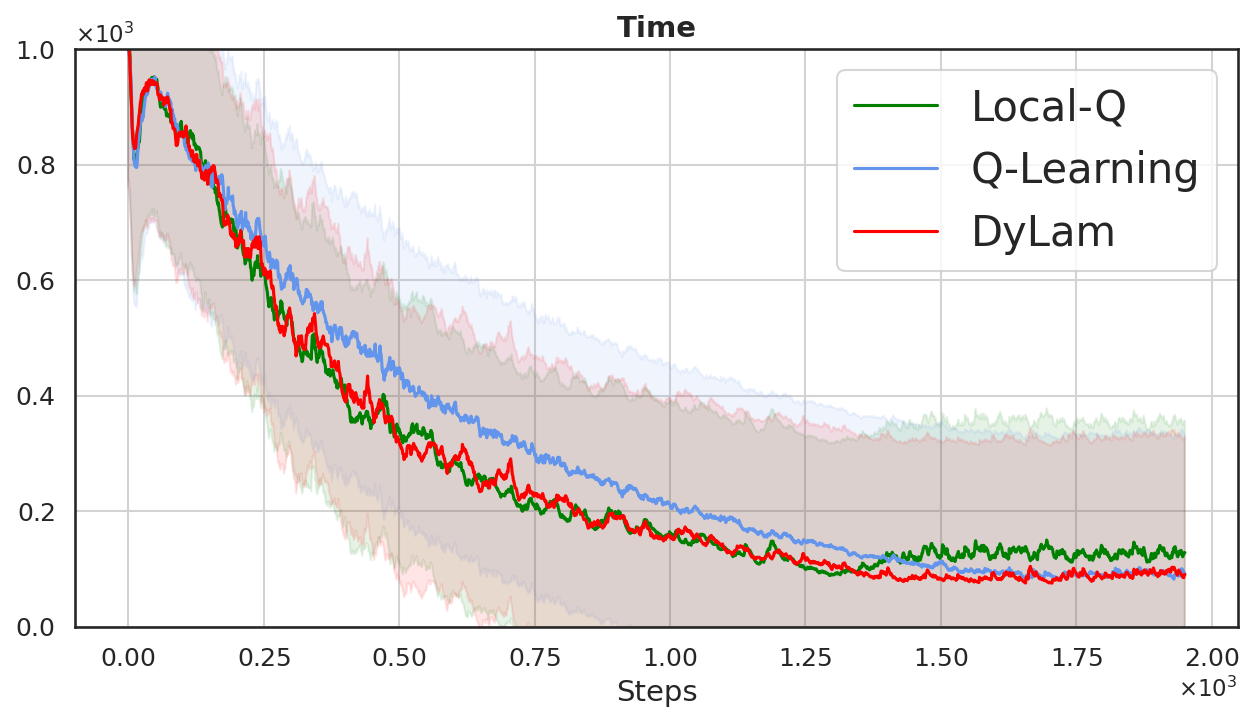

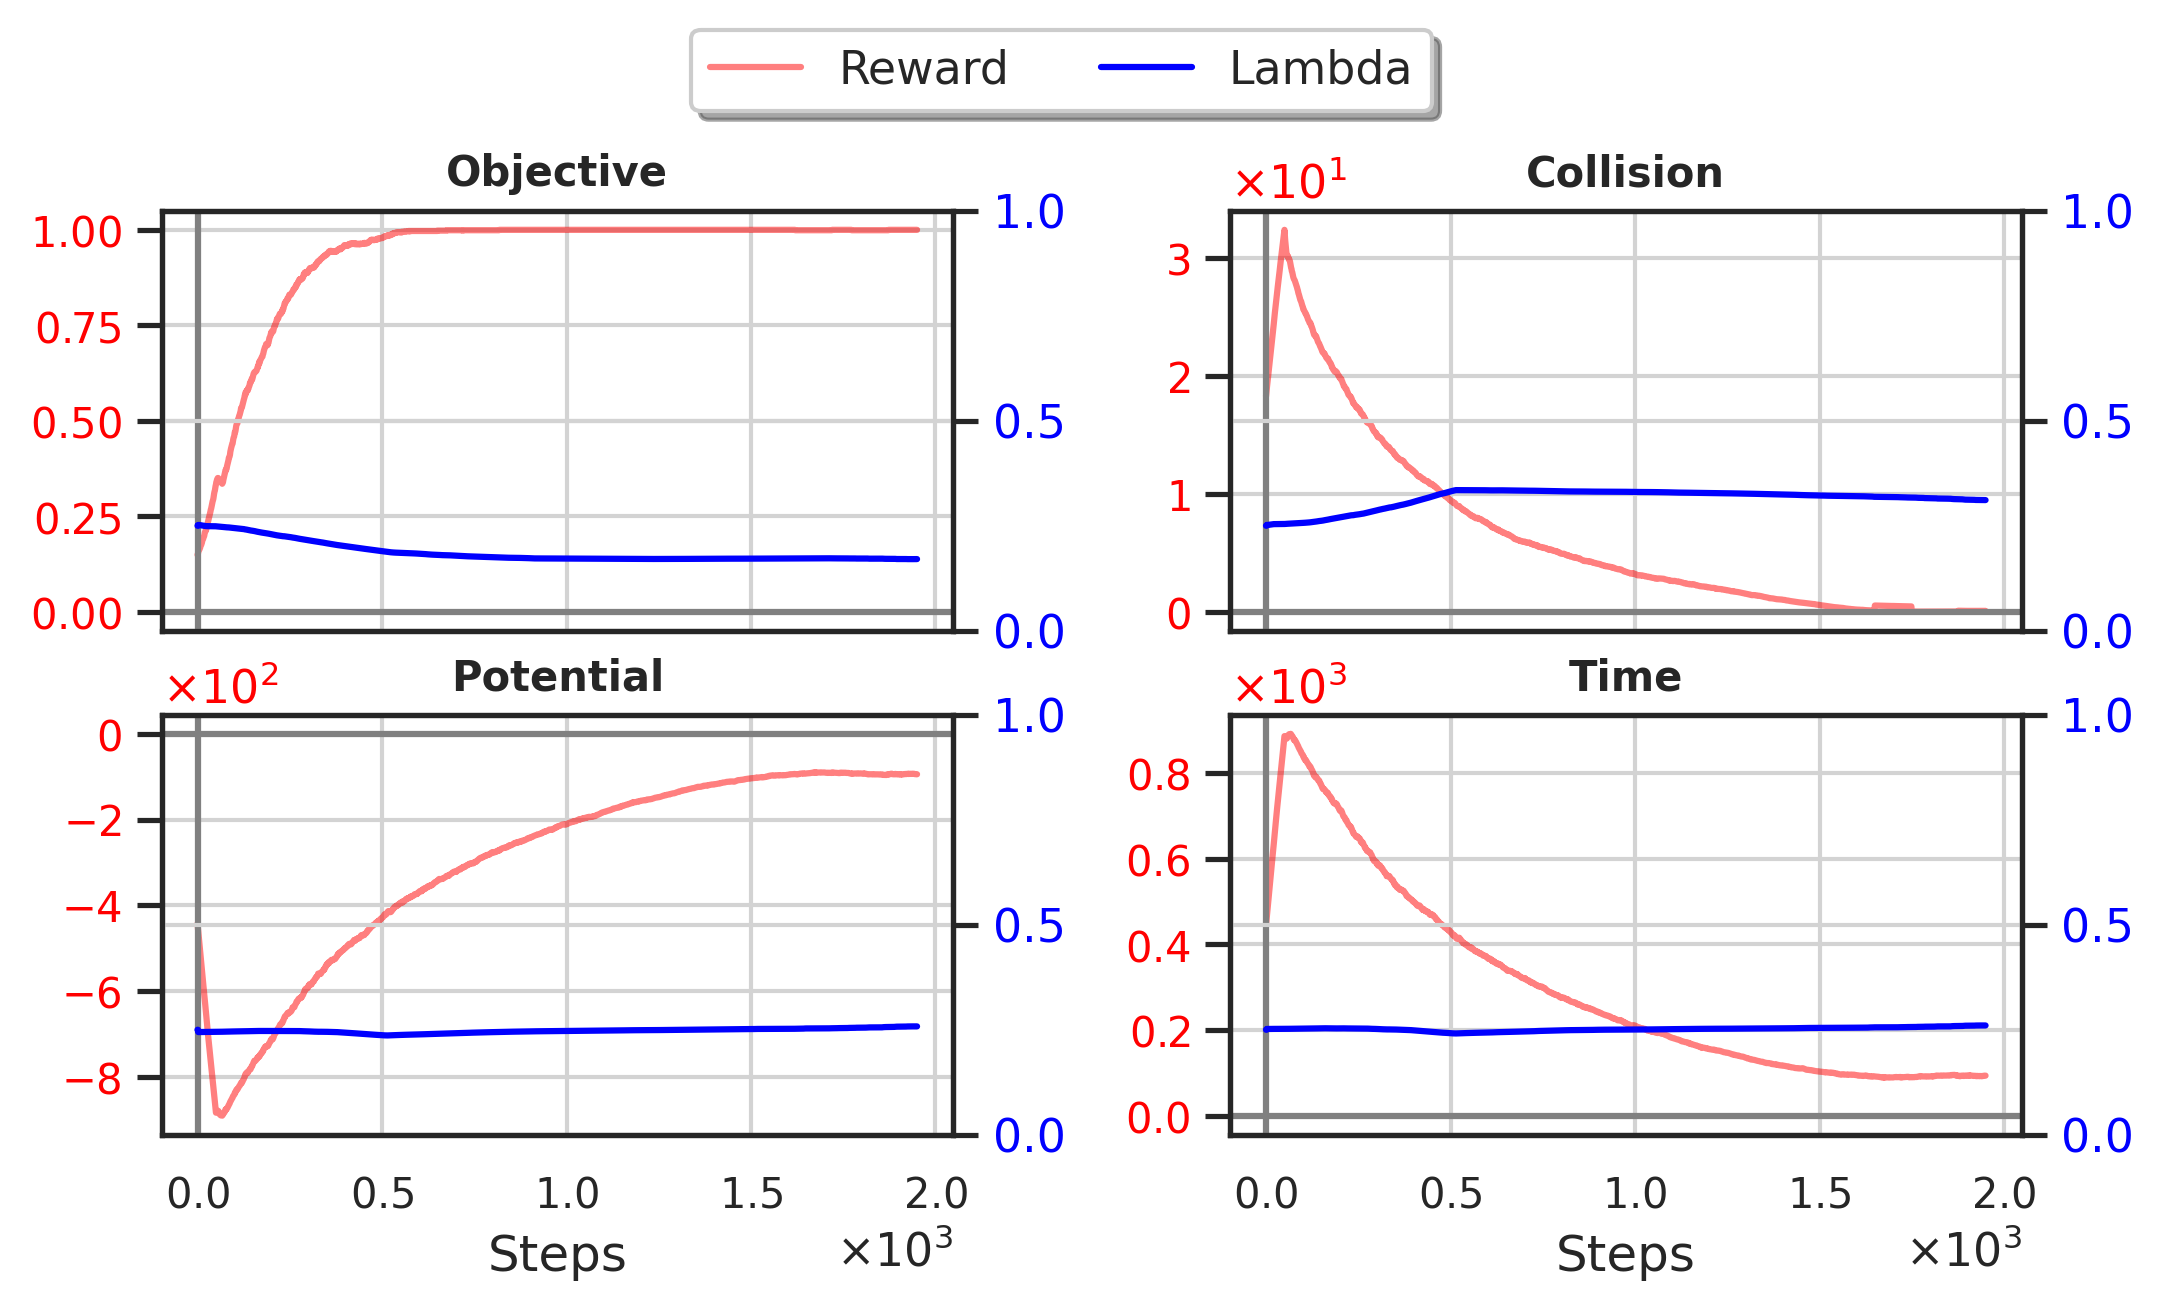

In [50]:
for env in environments:
    plot_results(env, results)
    plot_grid(lambdas, components, env)